<a href="https://colab.research.google.com/github/gvtsch/Udemy_TensorFlow_Certificate/blob/main/06_transfer_learning_with_TensorFlow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Our baseline to beat 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Jun 27 20:21:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8    11W /  N/A |    654MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper funtions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [5]:
import os

if not os.path.exists("helper_functions.py"):
  # !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
  !python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_notification notebook.

In [7]:
if not os.path.exists("101_food_classes_10_percent/"):
  # !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
  !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
  unzip_data("101_food_classes_10_percent.zip")

In [8]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [9]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [10]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a model checkpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [11]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [12]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale(1/255.) # Rescale inputs to 0 between, if not already rescaled like EfficientNet
], name="data_augmentation")

In [13]:
# Setup the base_model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (this only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
# Get summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [16]:
# Fit it for 5 epochs
initial_epochs = 5

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)), # validate on 15%
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="101_food_classes_10_percent"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/101_food_classes_10_percent/20220628-053128


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
237/237 [==============================] - 117s 446ms/step - loss: 3.4767 - accuracy: 0.2481 - val_loss: 2.6813 - val_accuracy: 0.4044
Epoch 2/5
237/237 [==============================] - 83s 351ms/step - loss: 2.3617 - accuracy: 0.4622 - val_loss: 2.2394 - val_accuracy: 0.4642
Epoch 3/5
237/237 [==============================] - 73s 307ms/step - loss: 1.9779 - accuracy: 0.5303 - val_loss: 2.0547 - val_accuracy: 0.4846
Epoch 4/5
237/237 [==============================] - 69s 289ms/step - loss: 1.7601 - accuracy: 0.5760 - val_loss: 2.0011 - val_accuracy: 0.4865
Epoch 5/5
237/237 [==============================] - 60s 253ms/step - loss: 1.5951 - accuracy: 0.6096 - val_loss: 1.9431 - val_accuracy: 0.4981


In [17]:
# Evaluate on the whole test dataset
model.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.7258 - accuracy: 0.5483


[1.7257566452026367, 0.5483168363571167]

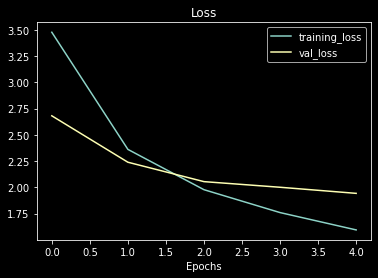

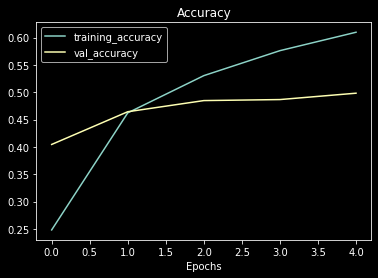

In [18]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: Ideally, the two curves should be pretty similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [19]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze verey layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically best practive to lower the learning rate when fine-tuning).
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr lowered by 10x
    metrics=["accuracy"]
)

In [21]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [22]:
# Check which layers are trainable in our base model?
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [25]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5 + 5)

# Fit the model
history_all_classes_10_percent_fine_tuned = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_all_10_percent), # not neccessary according to a question in udemy. 
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    initial_epoch=history_all_classes_10_percent.epoch[-1],
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="all_classes_10_percent_fine_tune"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_fine_tune/20220628-054812
Epoch 5/10


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


237/237 [==============================] - 56s 237ms/step - loss: 1.4791 - accuracy: 0.6364 - val_loss: 1.9213 - val_accuracy: 0.4966
Epoch 6/10
237/237 [==============================] - 53s 225ms/step - loss: 1.3873 - accuracy: 0.6562 - val_loss: 1.8971 - val_accuracy: 0.5026
Epoch 7/10
237/237 [==============================] - 50s 212ms/step - loss: 1.3028 - accuracy: 0.6739 - val_loss: 1.9051 - val_accuracy: 0.4950
Epoch 8/10
237/237 [==============================] - 50s 210ms/step - loss: 1.2246 - accuracy: 0.7011 - val_loss: 1.9102 - val_accuracy: 0.4981
Epoch 9/10
237/237 [==============================] - 49s 208ms/step - loss: 1.1496 - accuracy: 0.7127 - val_loss: 1.8600 - val_accuracy: 0.5114
Epoch 10/10
237/237 [==============================] - 47s 198ms/step - loss: 1.0866 - accuracy: 0.7430 - val_loss: 1.8536 - val_accuracy: 0.5159


In [29]:
# Evaluate on the whole test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 71s 89ms/step - loss: 1.6370 - accuracy: 0.5657


[1.6370251178741455, 0.565742552280426]

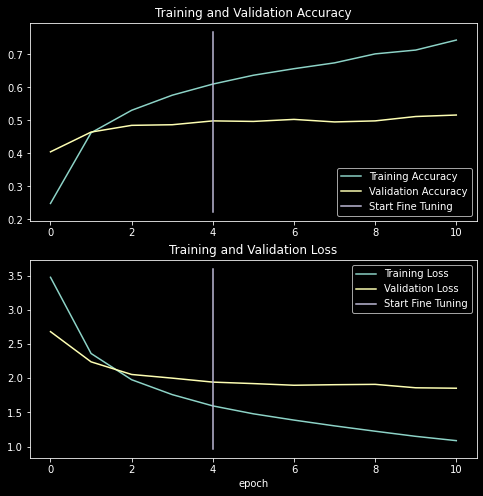

In [31]:
# Compare the historie of feature extraction model with fine-tuning model
compare_historys(
    original_history=history_all_classes_10_percent, 
    new_history=history_all_classes_10_percent_fine_tuned, 
    initial_epochs=5
)

## Saving and loading our model

To use our model in an external application, we'll save it and export somewhere

In [32]:
# Save our fine-tuned model
model.save("101_food_classes_10_percent/saved_trained_model/")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent/saved_trained_model/assets


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent/saved_trained_model/")

In [35]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 71s 89ms/step - loss: 1.6370 - accuracy: 0.5657


[1.6370251178741455, 0.565742552280426]

In [38]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tuned_results

[1.6370251178741455, 0.565742552280426]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [42]:
import tensorflow as tf
import os

# Download pretrained mode (one that was prepared earlier, so all predictions are similar)
if not os.path.exists("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip"):
    !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
if not os.path.exists("07_efficientnetb0_fine_tuned_101_classes_mixed_precision"):
    unzip_data("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip")

In [48]:
# Load in saved model
# model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [49]:
# Evaluate loaded model (the one we just downloaded on test data)
# results_downloaded_model = model.evaluate(test_data)
# results_downloaded_model

The model from dbourke isn't working in my case. That's why i am using my own loaded model for further work.

## Making predictions with our trained model

In [50]:
# Make predictions with model
preds_probs = loaded_model.predict(test_data, verbose=1) # set verborsity to see how long is left

790/790 [==============================] - 68s 85ms/step


In [51]:
len(test_data)

790

In [52]:
# How many predictions are there?
len(preds_probs)

25250

In [53]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [54]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[2.1892658e-01, 1.7999565e-04, 6.5498419e-02, ..., 1.4018068e-04,
        1.5542877e-03, 1.8559998e-01],
       [9.3593389e-01, 2.9630792e-07, 5.3656817e-04, ..., 4.2633322e-04,
        9.0475004e-07, 1.6666295e-06],
       [2.3277692e-01, 2.7895800e-03, 7.3765391e-03, ..., 9.5484272e-04,
        2.1135681e-03, 6.8649221e-03],
       ...,
       [5.1859868e-01, 1.6626367e-05, 1.1567477e-03, ..., 1.8406518e-02,
        5.5162539e-04, 2.5720731e-04],
       [1.4192736e-01, 6.9239503e-04, 6.9072597e-02, ..., 5.7484559e-04,
        3.5254203e-04, 7.6392817e-04],
       [5.3036755e-01, 1.0255848e-05, 1.4568632e-03, ..., 5.7214289e-03,
        4.8844879e-05, 4.8177652e-03]], dtype=float32)

In [58]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([2.18926579e-01, 1.79995652e-04, 6.54984191e-02, 4.70018193e-07,
        8.51854293e-06, 5.14893645e-06, 2.07535108e-04, 6.13238662e-05,
        2.91395616e-02, 2.96188425e-03, 5.67262323e-05, 4.86556064e-06,
        2.64779408e-03, 6.60726846e-06, 4.93487008e-02, 1.31282245e-03,
        1.24287879e-04, 2.66818213e-03, 1.25663215e-03, 1.76287958e-05,
        5.88946335e-04, 1.09072396e-04, 8.60903470e-04, 1.04049279e-03,
        8.33238126e-04, 1.62948994e-03, 1.78463745e-03, 2.66211631e-04,
        7.88679048e-02, 3.83399753e-03, 1.03204411e-05, 9.69134038e-04,
        1.30325882e-03, 1.09959740e-06, 6.41045859e-03, 1.24117592e-04,
        2.50013662e-03, 7.02978345e-04, 4.10416424e-02, 3.61666280e-05,
        2.74749851e-04, 2.14123004e-03, 1.54402782e-03, 2.17528632e-05,
        4.25683946e-04, 2.64956383e-04, 4.86693298e-03, 1.98165420e-04,
        3.26182931e-06, 2.29221247e-02, 7.48885912e-04, 5.64377588e-05,
        1.08348064e-01, 3.27416211e-02, 1.99535170e-05, 1.320764

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [61]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n{preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {tf.argmax(preds_probs[0])}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: 
[2.18926579e-01 1.79995652e-04 6.54984191e-02 4.70018193e-07
 8.51854293e-06 5.14893645e-06 2.07535108e-04 6.13238662e-05
 2.91395616e-02 2.96188425e-03 5.67262323e-05 4.86556064e-06
 2.64779408e-03 6.60726846e-06 4.93487008e-02 1.31282245e-03
 1.24287879e-04 2.66818213e-03 1.25663215e-03 1.76287958e-05
 5.88946335e-04 1.09072396e-04 8.60903470e-04 1.04049279e-03
 8.33238126e-04 1.62948994e-03 1.78463745e-03 2.66211631e-04
 7.88679048e-02 3.83399753e-03 1.03204411e-05 9.69134038e-04
 1.30325882e-03 1.09959740e-06 6.41045859e-03 1.24117592e-04
 2.50013662e-03 7.02978345e-04 4.10416424e-02 3.61666280e-05
 2.74749851e-04 2.14123004e-03 1.54402782e-03 2.17528632e-05
 4.25683946e-04 2.64956383e-04 4.86693298e-03 1.98165420e-04
 3.26182931e-06 2.29221247e-02 7.48885912e-04 5.64377588e-05
 1.08348064e-01 3.27416211e-02 1.99535170e-05 1.32076405e-02
 1.98271964e-02 9.49425437e-03 2.42477586e-

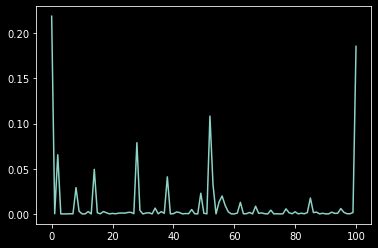

In [64]:
# Visualize the probabilities
matplotlib.pyplot.plot(preds_probs[0])

In [67]:
test_data.class_names[tf.argmax(preds_probs[0])]

'apple_pie'

In [74]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29,  0,  9,  0], dtype=int64)